In [1]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 1.Tiền xử lý dữ liệu

In [2]:
df = pd.read_csv("/content/drive/MyDrive/AI/dataset/Energy_Weather.csv")
df

,kilowatt-hours,Date,TempMin,TempMax,Weather,Wind_speed,Humidity,ALLSKY_SFC_SW_DWN
0,2.165,2019-01-28,18,23,Patchy rain possible,2.81,88.88,1.99
1,6.470,2019-01-29,20,25,Patchy rain possible,3.48,88.50,2.83
2,9.157,2019-01-30,21,24,Patchy rain possible,3.29,87.06,5.41
3,16.269,2019-01-31,21,25,Sunny,1.98,82.44,5.83
4,8.447,2019-02-01,19,23,Moderate rain at times,2.64,83.88,5.06
...,...,...,...,...,...,...,...,...
1757,4.514,2023-11-20,21,23,Light rain shower,3.85,85.00,4.07
1758,11.096,2023-11-21,22,26,Patchy rain possible,2.61,82.06,4.53
1759,4.860,2023-11-22,20,25,Light rain shower,2.69,84.19,2.83
1760,13.984,2023-11-23,23,25,Light rain shower,3.73,85.31,4.98


In [ ]:
# # Chuyển cột 'Timestamp' sang kiểu datetime
# df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# # Lấy chỉ thời gian và định dạng thành chuỗi '00:00:00'
# df['Time'] = df['Timestamp'].dt.strftime('%H:%M:%S')

# df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# # Tạo cột mới cho giờ
# df['Hour'] = df['Timestamp'].dt.hour

# df['Date'] = df['Timestamp'].dt.date

# df['YearMonth'] = df['Timestamp'].dt.to_period('M').astype(str)

# df

In [ ]:
# df_tem = df.groupby(["Date", "Weather"]).agg({'TempMin': 'mean', 'TempMax': 'mean', 'Watt': 'sum'}).reset_index()
# #df_tem = df_tem.drop(columns=["Date"], axis=1)
# df_tem

In [3]:
weather = {'Patchy rain possible': 0.27,
           'Sunny': 0.99,
           'Moderate rain at times': 0.22,
           'Overcast': 0.5,
           'Partly cloudy': 0.67,
           'Cloudy': 0.56,
           'Heavy rain at times': 0.16,
           'Moderate or heavy rain shower': 0.11,
           'Light rain shower': 0.33,
           'Mist': 0.44,
           'Patchy light rain with thunder': 0.24,
           'Thundery outbreaks possible': 0.31,
           'Patchy light drizzle': 0.39,
           'Torrential rain shower': 0.01
}

df['Weather'] = df['Weather'].map(weather)
df = df.drop(columns=["Date"], axis=1)
df

,kilowatt-hours,TempMin,TempMax,Weather,Wind_speed,Humidity,ALLSKY_SFC_SW_DWN
0,2.165,18,23,0.27,2.81,88.88,1.99
1,6.470,20,25,0.27,3.48,88.50,2.83
2,9.157,21,24,0.27,3.29,87.06,5.41
3,16.269,21,25,0.99,1.98,82.44,5.83
4,8.447,19,23,0.22,2.64,83.88,5.06
...,...,...,...,...,...,...,...
1757,4.514,21,23,0.33,3.85,85.00,4.07
1758,11.096,22,26,0.27,2.61,82.06,4.53
1759,4.860,20,25,0.33,2.69,84.19,2.83
1760,13.984,23,25,0.33,3.73,85.31,4.98


# 2.Tạo dữ liệu

In [4]:
from sklearn.model_selection import train_test_split

X = []
y = []

n = 14
m = 1

dataframe = df.values
for i in range(len(dataframe) - (m + n)):
    X.append(dataframe[i:i+n, 0:1])
    y.append(dataframe[i+n:i+n+m, 0])
X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(1747, 14, 1) (1747, 1)


# 3.Huấn luyện

### 3.1. LSTM

In [ ]:
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dense


def build_lstm(X_train, y_train):
    n_samples, timesteps, n_feature = X_train.shape
    model = Sequential()
    model.add(LSTM(200, activation="tanh", input_shape=(timesteps, n_feature)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_feature))
    model.compile(loss="mse", optimizer='adam', metrics=["mae"])
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
    return model

md = build_lstm(X_train, y_train)
print(md.evaluate(X_test, y_test, verbose=0))

### 3.2 CNN-LSTM

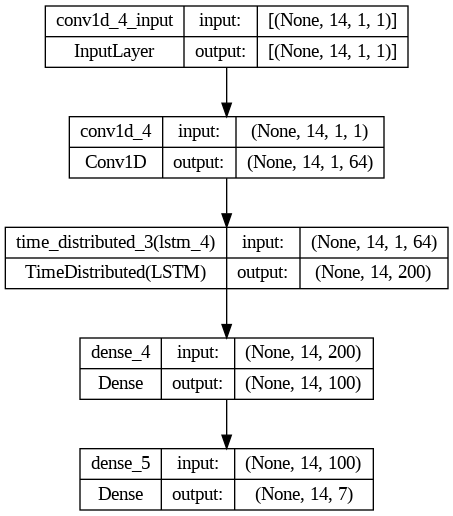

In [9]:
from keras.layers import Conv1D
from keras.layers import MaxPool1D
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Input, TimeDistributed
from keras.utils import plot_model

def build_cnn_lstm(X_train, y_train):
    n_samples, time_step, n_feature = X_train.shape
    lstm_layer = LSTM(200, activation="tanh")

    md = Sequential()
    # md.add(Input(time_step, n_feature))
    md.add(Conv1D(64, padding="same", kernel_size=3, activation="relu", input_shape=(time_step, n_feature, 1)))
    md.add(TimeDistributed(lstm_layer))
    md.add(Dense(100, activation='relu'))
    md.add(Dense(n_feature))
    md.compile(loss="mse", optimizer="adam", metrics=["mae"])
    # md.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)
    return md

cnn_lstm = build_cnn_lstm(X_train, y_train)
plot_model(cnn_lstm, show_shapes=True)
# print(cnn_lstm.evaluate(X_test, y_test, verbose=0))

In [ ]:
df["kilowatt-hours"].describe()

count    1762.000000
mean       12.608906
std         5.688927
min         0.000000
25%         8.749000
50%        13.824000
75%        16.858500
max        26.024000
Name: kilowatt-hours, dtype: float64

## 3.3 Conv LSTM custom


In [ ]:
from keras import Model
from keras.layers import Input, Dense, MaxPooling1D, Conv1D, LSTM, Flatten, RepeatVector
from keras.layers import Dropout, Add, concatenate
from keras.utils import plot_model


def build_custom_model(X_train, y_train):
    n_samples, time_step, n_feature = X_train[0].shape
    input_1 = Input(shape=(time_step, n_feature))
    x1 = Conv1D(filters=64, kernel_size=3, activation='relu')(input_1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Conv1D(filters=128, kernel_size=3, activation='relu')(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Dropout(0.2)(x1)
    x1 = Flatten()(x1)
    x1 = RepeatVector(time_step)(x1)
    x1 = LSTM(200, activation='tanh')(x1)
    x1 = Dropout(0.2)(x1)
    x1 = Dense(100, activation='relu')(x1)
    x1 = Dense(1)(x1)

    input_2 = Input(shape=(time_step, 1))
    x2 = LSTM(200, activation='tanh')(input_2)
    x2 = Dropout(0.2)(x2)
    x2 = Dense(100, activation='relu')(x2)
    x2 = Dense(1)(x2)

    x = concatenate([x1, x2])
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(7)(x)

    md = Model(inputs=[input_1, input_2], outputs=output)
    md.compile(loss="mse", optimizer="adam", metrics=["mae"])
    md.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)
    return md

train_1 = X_train[:,:,1:]
train_2 = X_train[:,:, 1]
md = build_custom_model([train_1, train_2], y_train)

Epoch 1/100
87/87 [==============================] - 6s 7ms/step - loss: 70.0108 - mae: 6.7372
Epoch 2/100
87/87 [==============================] - 1s 7ms/step - loss: 37.4950 - mae: 5.0179
Epoch 3/100
87/87 [==============================] - 1s 7ms/step - loss: 34.0200 - mae: 4.7872
Epoch 4/100
87/87 [==============================] - 1s 7ms/step - loss: 31.9835 - mae: 4.6147
Epoch 5/100
87/87 [==============================] - 1s 7ms/step - loss: 31.3784 - mae: 4.5583
Epoch 6/100
87/87 [==============================] - 1s 7ms/step - loss: 30.2694 - mae: 4.4568
Epoch 7/100
87/87 [==============================] - 1s 7ms/step - loss: 30.3175 - mae: 4.4703
Epoch 8/100
87/87 [==============================] - 1s 7ms/step - loss: 30.5899 - mae: 4.5054
Epoch 9/100
87/87 [==============================] - 1s 7ms/step - loss: 30.1655 - mae: 4.4616
Epoch 10/100
87/87 [==============================] - 1s 7ms/step - loss: 28.8577 - mae: 4.3742
Epoch 11/100
87/87 [=============================

In [ ]:
test_1 = X_test[:,:,:-1]
test_2 = X_test[:,:, -1]
print(md.evaluate([test_1, test_2], y_test, verbose=0))
print(md.predict([test_1, test_2], verbose=0)[:7])
print(y_test[0])

[338.29302978515625, 14.93432331085205]
[[27.247032]
 [46.30484 ]
 [64.57392 ]
 [60.77286 ]
 [46.20261 ]
 [26.348846]
 [36.33568 ]]
[19.272358 11.93189  13.724976 41.46099  15.496222 49.91443  37.246283]
